# Statistical Testing Workshop

## Summary
- Comparing means works because of CLT.
- When comparing means use the $t$-test unless:
  - you know the variance
  - you have a ton of data
- The $z$-test and $t$-test have a few variations:
  - **One or Two Sample Test**: One-sample when you compare the mean to a fixed value. Two-sample when you compare one mean to another mean. 
  - **One or Two Tail Tests** Use one tail if you want to show test is the means are less than or greater than a value. Use two tail tests if you only care whether or not the means differ. 
  - **Paired or Unpaired** Use a paired test if each participant gets both treatments. 
- Use power analysis to choose the sample size you need.


## 1 Introduction
This workshop assumes you know the basics of probability, but not very much.
 
I will be using python for examples and I will use the following libraries:

In [0]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.api as sm

### 1.1 Decide what to test

While it's obvious that you need to decide on what to test, this part always seems to be one of the most difficult parts. Typically we are approached with a vague idea of what Juvo would like to demonstrate to some stakeholders. For example, we might want to change the fee structure of airtime loans. We get a carrier to agree to test which fees are best, but what do we test? What does best mean? We need to clearly define a metric that all parties can agree represents what we mean by "best". In this example, we might want to decrease fees because it increases retention. The carrier comes back uninterested in retention because they are unsure if the potential increase in retention would offset the profit lost by lowering fees. After some back and forth, we both agree that the best measure is average revenue per user (or ARPU) since we know the longer users stick around the more they will spend overall, and the carrier agrees because it is a strong indicator of profit. This is an important back and forth to have. At the end of the day, it is not up to the data scientist to choose this. While we may have a strong opinion on what the best metric is, it is a worthless metric if all stakeholders don't agree on the final meaning of it. 



### 1.2 Decide on the test
There are plenty of statistical test to choose from. A quick and dirty reference for which test to use when can be found [here on the UCLA website](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/). Note the disclaimer at the top which states
> We emphasize that these are general guidelines and should not be construed as hard and fast rules.

Some questions that need to be answered first are typically:

  - Is the data continuous, ordinal, or discrete 
  - How is that data distributed?
  - Does the variance change? There are often an assumption of homogeneity, i.e. assumptions that the variance within samples are the same.
  - Do you have enough data? The more complicated the test, the more data you need. 
  - How many groups do you have?
  - Do you have a control?
  - How many variables do you have?
  - How many levels do you have for each variable?
  - Do you  expect interaction between variables?
  
All of these will help narrow down what test to use. Check all of the assumptions of the test and make sure they are statisfied before using it. 


### 1.3 Decide how to get the participants
  It is important to make sure that we keep the data pure. The main assumption for these tests is that you choose the participants of the test that is sufficiently random. We need the samples to avoid accidentally picking up a signal that we didn't intend to.

  This can sometimes be harder to do than it seems. For example, say we want to change fees. It might not be best to just randomly select existing users because we can have a user who has taken a loan before at the default rate, say R$2, but they get assigned to the treatment group that gives them a rate of R\$2.5. This user might be annoyed that they suddenly got a price hike and drive them to change the way they would normally behave. We could filter out all users who have taken out loans. However, users who have never taken a loan might be the more financially stable and don't properly represent the whole population. It might be best to only take new users, but we would have to check if they carrier get enough new users to support that test. All in all, this can be a difficult part of the design to sort out with many moving parts so don't think this is a quick step.

  Avoid filtering as much as possible. Always be mindful of how the sample generalizes to the whole population.


### 1.4 Central Limit Theorem

The [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) is key to understanding where these tests come from so let's take a second to review it. 

***Central Limit Theorem***: Let $\{X_1,\cdots, X_n\}$ be an independent and identically distributed random sample with $\mathbb E(X_i) = \mu$ and variance $Var(X_i) = \sigma^2$ for any $i$. Also let 
$$
  S_n = \frac{X_1+\cdots+X_n}{n}.
$$
Then the random variable $\sqrt n(S_n - \mu)$ converges in distribution to $\mathcal N(0,\sigma^2)$. or equivalently 


Notice no assumptions are being made about the distribution of $X_i$. It can be from any distribution, and as the sample size gets large, the distribution of the sample mean is approximately normal. To demonstrate this, I calculated the means with four different sample sizes (2, 10, 100 and  1000) and plotted this histogram. I also plot the PDF of the normal distribution described int he central limit theorem to see how well it approximates the data. 




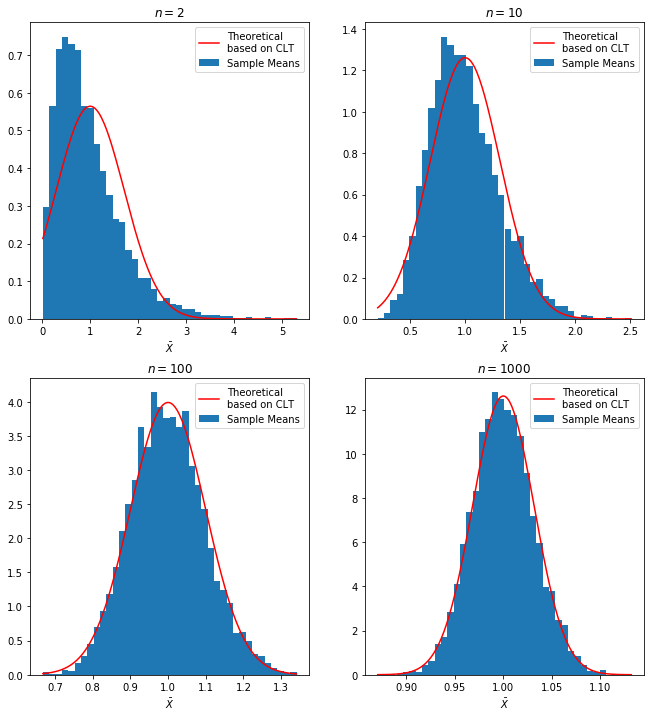

In [0]:
#@title Sample mean histogram with exponentially distributed data
plt.figure(1, figsize=[11,12])
nbins = 40
N = [2,10,100,1000]
for i in range(len(N)):
  plt.subplot(2,2, i+1)
  # simulating means of samples from exponential distribution
  n = N[i]
  X_bar = []
  mu, sigma = [1, 1] # The true mean and variance
  for i in range(5000):
    X_i = ss.expon().rvs(n)
    X_i_bar = sum(X_i)*1.0/n
    X_bar.extend([X_i_bar])

  # the theoretical distribution of the means given by CLT
  x = np.linspace(min(X_bar),max(X_bar),200)
  y = ss.norm(mu,sigma/np.sqrt(n)).pdf(x)
  plt.hist(X_bar, 
           density=True, 
           bins=nbins,
           label="Sample Means")
  plt.plot(x, y, c="red", label="Theoretical\nbased on CLT")
  plt.title("$n=${}".format(n))
  plt.xlabel(r"$\bar X$")
  plt.legend()
  
# plt.suptitle("Sample mean histogram with exponentially distributed data",fontsize=16)
plt.show()

Here is some more CLT action:
<center>
<img align="center" src="https://media.giphy.com/media/VGtj8lltdM34oW1gEH/giphy.gif" width="480" />
</center>

----
## 2 Hypothesis Testing
In this section we cover how to run a test in more mathematical detail.

### 2.1 Hypothesis
All experiments start with two Hypothesis, the null hypothesis and the alternative hypothesis. The ***null hypothesis*** is a statement that is the default truth. If there are no conclusive result from the test, we fall back to the null hypothesis as the working truth. We denote the null hypothesis as $H_0$. The ***alternative hypothesis*** is a counter statement to the null hypothesis. It is the statement that carries with it the burden of proof. We denote the alternative hypothesis is $H_a$, or some might denote it as $H_1.$ 

In A/B tests we are trying to show the difference between the two populations and we might do that by comparing the means of the agreed upon measurement. So for example, we might want to see if lowering the fees has an affect on ARPU (Average Revenue Per User). So we define group $A$ to be the group with no change in fees and define group $B$ be the group with the lower fee. You can image that would run this test and try to convince a telco to change their fee structure. If we don't have proof, they will just laugh in our face so the burden of proof lies with the statement that the ARPUs of group $A$ and $B$ are different. We denote the ARPUs of group $A$ and $B$ as $\mu_A$ and $\mu_B$, respectively. So the hypotheses we are testing are as follows:

\begin{align*}
 H_0&: \mu_A = \mu_B\\
 H_a&: \mu_A \neq \mu_B
\end{align*}

Each test has a similar structure. Assuming the null hypothesis is true, we calculate the test statistic of our sample. With that we can then find the probability of getting that statistic assuming the null hypothesis is true. We call that probability the $p$-value.

Once we have the results of the test we have to make a decision on the hypotheses. We will have two options: We either reject the null hypothesis or we fail to reject the null hypothesis. Notice we never make a definitive conclusion about the alternative hypothesis. The truth is the way these frequentist test are constructed, all of the analysis is done assuming the null hypothesis is true so the most definitive statement we can make is only about the null hypothesis. 



### 2.2 Type I and Type II error
In this type of test, there are two ways we can be wrong. Either we can reject $H_0$ while in reality $H_0$ was in fact true, or we can accept $H_0$ while in reality $H_0$ False. These errors are called ***type I*** and ***type II*** errores respectively.

<center>
<img src="https://peterattiamd.com/wp-content/uploads/2018/02/null-1.jpeg" width="480" align="center"/>
</center>

To talk about this more precisely lets define $\alpha= P(\text{reject }H_0 | H_0 \text{ is true})$ and $\beta = P(\text{accept }H_0 | H_0 \text{ is false})$. Typically, we talk more about the complement of $\beta$, i.e. $1-\beta$, which we call the ***power*** The probabilities of each scenario are given in the table below. 
 

|   &#xfeff;  |$H_0$ is true|$H_0$ is false|
|----:|:-----------:|:-----------:|
|**accept $H_0$**| Correct<br> $1-\alpha$| Type II<br>$\beta$
|**reject $H_0$**|Type I <br> $\alpha$| Correct<br>$1-\beta$


### 2.3 Power
The term $1-\beta$ or the probability of correctly rejecting the null hypothesis is so important that we give it a name. It is called the ***power*** of the test. In hypothesis testing, on top of allowing us to understand how we can be wrong it also helps us determine the sample size we need. We will revisit this after we define some test. 

----
## 3 Basic Tests

### One Sample $z$-Test 
This is not a very useful example in practice but it sets the foundation for some of the tests we will discuss later. For this test we assume we have collected data $\{y_1, y_2, \cdots , y_n \}$ that we know comes from a normally distributed random variable $Y\sim\mathcal N (\mu,\sigma^2)$, where we know $\sigma^2$, but we don't know $\mu$.

The assumptions are:
  1. Each $y_i$ comes from a normal random variable $Y\sim\mathcal N (\mu,\sigma^2)$. 
  2. We know the variance $\sigma^2$
  3. We don't know the mean $\mu$

The hypothesis for the following are:
\begin{align*}
H_0: \mu=\mu_0\\
H_a: \mu\neq \mu_0\\
\end{align*}

The test statistic is 
$$z = \frac{\mu_o - \bar y}{\sigma/\sqrt{n}}\sim \mathcal N (0,1)$$
Where $\bar y = \frac{1}{n}\sum_{i=1}^{n}y_i$. If we assume the null hypothesis we know that our sample should be close to the mean of the null hypothesis $\mu_0$. If it is drastically far from the null hypothesis mean, then that is evidence that the null hypothesis is wrong and thus evidence that the alternative might be correct. So we have to choose a significance level $\alpha$ that defines how far from $\mu_0$ to justify rejecting $H_0$. Often, in the literature, we choose $\alpha = 0.05$. So we are checking the sample mean and we are calculating the probability of getting a sample mean that extreme. If the probability is less than 5% we reject the null hypothesis. We call that probability that we calculate the $p$-value.

### Example: $z$-test
Assume we are given a data set and we are told that the variance is 1. And we want to know if the data has a mean other than zero. So our hypothesis are:

\begin{align*}
H_0: \mu =  0 \\
H_a: \mu \neq 0 \\
\end{align*}

Below is the data given and a histogram of the data (in blue) compared to the null hypothesis PDF (in orange).



In [0]:
sigma = 1.0 # This is told to us. 

# The data is given to us. 
data = np.array([ 0.97371708,  2.13760344,  1.49854198, -0.20740687, -0.5422073 ,
                  0.49418656, -0.99368848, -1.07993323, -0.11793051,  0.25949674,
                 -0.22658541,  0.42806121,  1.0422869 , -0.63654469,  1.5448586 ,
                  1.03634436,  0.17327545,  0.88830785,  1.42613701,  0.70109459,
                  1.92066165,  0.59662308, -0.20690922,  0.37928897, -0.72141141,
                 -0.66878324, -1.81805308,  0.29813668, -0.09224128,  2.49288298
                ])

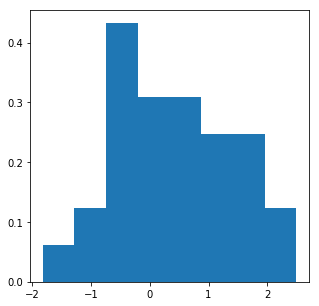

In [0]:
#@title Histogram of the Data
plt.figure(1, figsize=[5,5])
plt.hist(data, 
         bins=8, 
         density=True,
         label="Observed Data")
plt.show()
plt.close(1)

Let's now perform the test. We need to calculate the $z$ statistic. Then assuming $Z\sim\mathcal N(0,1)$, we need to calculate the probability of getting a $z$ statistic that extreme. This means we want to calculate the probability of getting a $z$ value that extreme. We do so by calculating the area under the PDF from $(-\infty, -|z|]$ and the area under $[|z|,\infty)$. Because of the symmetry of the normal distribution, we can calculate this as 
$$p = 2\cdot F_Z (-|z|)$$
Where $ F_Z $ is the CDF of the standard normal distribution, $z$. 

In [0]:
# define the z-distribution for convenience 
z_dist = ss.norm(0,1)

N = data.shape[0]

mu0 = 0.0 # null hypothesis
s = sigma/np.sqrt(N) # standard error
z = (data.mean()-mu0)/s

p_value = 2*z_dist.cdf(-abs(z))

# Dispaly results
print "Two-sided One-sample z-Test Results"
print "z Statistic:\t{x}".format(x=z)
print "P-Value:\t{}".format(p_value)

Two-sided One-sample z-Test Results
z Statistic:	2.00462994623
P-Value:	0.0450026227424


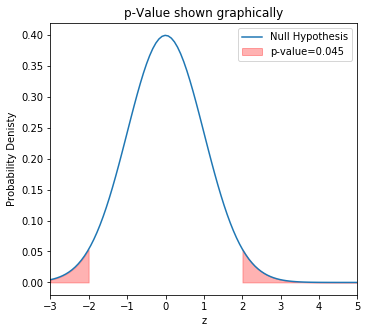

In [0]:
#@title Plot of p-values

x_min = -3
x_max = 5

# Plot the null hypothesis pdf and the p-values
x = np.linspace(x_min,x_max,100)
y = z_dist.pdf(x)
z_ub = np.linspace(abs(z),x_max,20)
z_lb = np.linspace(x_min,-abs(z),20)

# plotting
plt.figure(1, figsize=[5.5,5])
plt.fill_between(x=z_ub, 
                 y1=0, 
                 y2=z_dist.pdf(z_ub), 
                 alpha=0.3,
                 color="red")
plt.fill_between(x=z_lb, 
                 y1=0,
                 y2=z_dist.pdf(z_lb), 
                 alpha=0.3,
                 color="red", 
                 label="p-value={:.03f}".format(p_value))
plt.plot(x, y, label="Null Hypothesis")
plt.xlabel("z")
plt.ylabel("Probability Denisty")
plt.title("p-Value shown graphically")
plt.legend()
plt.xlim([x_min, x_max])
plt.show()
plt.close(1)

#### Two-sided vs. one-sided

What we just went though was specifically called a "two-sided" test. It is called two-sided because we calculate the probability from both sides of the distribution. For a two-sided test, we are testing whether or not the two means are the same or different. We don't care if one is larger or smaller than the other. So we state the alternative hypothesis simply as $\mu\neq\mu_0$.

It is also possible to have a one-sided test if we do care about direction. if we do care about the A one-sided test specifically seeks to test if one value is larger than the other. If we want to test if group A has a larger mean than group B, then we state the hypothesis as
\begin{align*}
  H_0 &: \mu = \mu_0  \\
  H_1 &: \mu < \mu_0  &&\text{or}&  H_2 &: \mu > \mu_0\\
\end{align*}
If we go back to two-sided example. Lets say that it is only important if the mean falls below zero. In that case we would want to test 
\begin{align*}
  H_0 &: \mu = 0  \\
  H_1 &: \mu < 0\\
\end{align*}
In this case, since we only care if the mean is negative, we only calculate the probability on the negative side of the distribution.
$$p= F_Z(z)$$

Likewise, if we only care if the mean is positive we use the alternative hypothesis of  $H_2 : \mu > 0$ and we calculate the $p$-value as 
$$p= 1 - F_Z (z)$$
Both cases are plotted below.



In [0]:
lessthan_p_value = z_dist.cdf(z)
greaterthan_p_value = 1-z_dist.cdf(z)

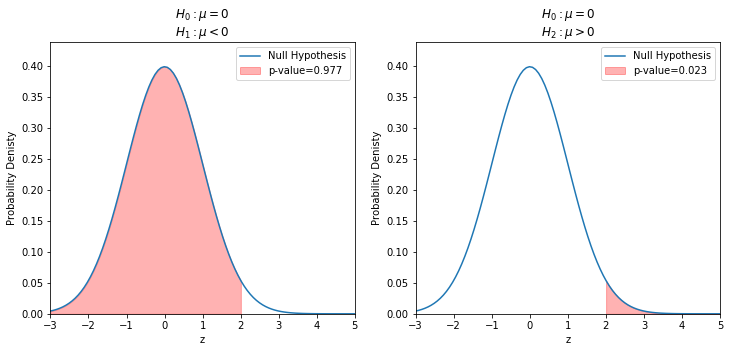

In [0]:
#@title p-Value of One-Sides Tests
x_min = -3
x_max = 5

z_lb = np.linspace(x_min,z,200)
z_ub = np.linspace(z,x_max,200)
x = np.linspace(x_min,x_max,100)
y = z_dist.pdf(x)

# plotting H_1
plt.figure(1, figsize=[12,5])
plt.subplot(1,2,1)
plt.fill_between(x=z_lb, 
                 y1=0, 
                 y2=z_dist.pdf(z_lb), 
                 color="red",
                 alpha=0.3,
                 label="p-value={:.03f}".format(lessthan_p_value))

plt.plot(x, y, label="Null Hypothesis")
plt.axhline(0, lw=1, c ="k")
plt.xlabel("z")
plt.ylabel("Probability Denisty")
plt.title("$H_0:\mu=0$\n$H_1: \mu < 0$")
plt.ylim([0,y.max()*1.1])
plt.legend()
plt.xlim([x_min, x_max])

# plotting H_2
plt.figure(1, figsize=[11,5])
plt.subplot(1,2,2)
plt.fill_between(x=z_ub,
                 y1=0, 
                 y2=z_dist.pdf(z_ub), 
                 color="red",
                 alpha=0.3, 
                 label="p-value={:.03f}".format(greaterthan_p_value))
plt.axhline(0, lw=1, c ="k")
plt.plot(x, y, label="Null Hypothesis")
plt.xlabel("z")
plt.ylabel("Probability Denisty")
plt.title("$H_0:\mu=0$\n$H_2: \mu > 0$")
plt.legend()
plt.xlim([x_min, x_max])
plt.ylim([0,y.max()*1.1])
plt.show()
plt.close(1)

In the case of $H_1:\mu<0$ there the $p$-value is too high to reject the null hypothesis. So there is little evidence that the mean is actually negative. While in the case of $H_2:\mu>0$  the $p$-value is small enough to reject the null hypothesis so there is evidence that the mean is positive. 

### Libraries for the $z$-test
Of course this is a common calculation to do, so we don't need to do all of the calculations from scratch. We can do the same calculation foe the two-sided $z$-test above with the following code:

In [0]:
z_results = sm.stats.ztest(data, 
                           value=0, 
                           alternative="two-sided")

print """H_a:  mu != 0
Test statistic, z:\t{}
p-value:\t\t{}""".format(z_results[0],z_results[1])

H_a:  mu != 0
Test statistic, z:	1.97395211523
p-value:		0.0483871880407


The numbers are slightly off becuase it is approximating the variance from the data instead of using the known variance that we fixed at 1. But the test is close enough to correct. 
Moreover, we can also do the one sided test for $H_1: \mu <0$ as follows:

In [0]:
z_results = sm.stats.ztest(data, 
                           value=0, 
                           alternative="smaller")

print """H_a: mu < 0
Test statistic, z:\t{}
p-value:\t\t{}""".format(z_results[0],z_results[1])

H_a: mu < 0
Test statistic, z:	1.97395211523
p-value:		0.97580640598


and using the alternative $H_2: \mu>0$ is done as follows:

In [0]:
z_results = sm.stats.ztest(data, 
                           value=0, 
                           alternative="larger")

print """H_a: mu > 0
Test statistic, z:\t{}
p-value:\t\t{}""".format(z_results[0],z_results[1])

H_a: mu > 0
Test statistic, z:	1.97395211523
p-value:		0.0241935940203


#### Power of the Test
Recall that power is the probability of correctly rejecting the null hypothesis. In other words, we want 
$P(\text{reject }H_0|H_a) = 1-\beta$.
Since $H_a: \mu\neq \mu_0$ is vague, we need to get a better idea of what the true mean $\mu$ actually is. So let $\delta$ be the amount that we are wrong about $\mu$ In other words $\mu= \mu_0 + \delta$.
\begin{align*}
1- \beta &= P(\text{reject }H_0|H_a \text{ is true})\\
              &= P(Z  > \mu_0 + \sigma_n z_{1-\alpha}|H_a)\\
              &=  1 - P(Z < \mu_0 + \sigma_n z_{1-\alpha}|H_a)\\
              &=  1 - P\left(\frac{Z-\mu}{\sigma_n} < \frac{\mu_0-\mu+ \sigma_n z_{1-\alpha}}{\sigma_n} \Big|H_a\right)\\
              &=  1  - F_Z \left( \frac{\mu_0-\mu}{\sigma_n} + z_{1-\alpha} \right)\\
              &=  F_Z \left( \frac{\mu-\mu_0}{\sigma_n} - z_{1-\alpha} \right) \hspace{1cm}\text{because of symmetry }\\
\end{align*}
Recall that in this case $\sigma_n =\sigma/\sqrt n$. We can plug this in and solve for $n$
\begin{align*}
1- \beta &=  F_Z \left( \frac{\mu-\mu_0}{\sigma/\sqrt n} - z_{1-\alpha} \right)\\
z_{1- \beta} &=   \frac{\mu-\mu_0}{\sigma/\sqrt n} - z_{1-\alpha}\\
z_{1- \beta} +  z_{1-\alpha} &= \frac{\mu-\mu_0}{\sigma/\sqrt n}\\
\frac{\sigma(z_{1- \beta} +  z_{1-\alpha})}{\mu-\mu_0} &= \sqrt n\\
\left[\frac{\sigma(z_{1- \beta} +  z_{1-\alpha})}{\mu-\mu_0}\right]^2 &=  n\\
\end{align*}

But again, most stats libraries will have functions to do this calculation for you.  You can use `zt_ind_solve_power` in the statsmodels library. Here the argument `effect_size` is the standardized difference in the means. i.e. it's the value of $(\mu-\mu_0)/\sigma$. 

In [0]:
sm.stats.zt_ind_solve_power(effect_size=0.1, 
                            nobs1=None, 
                            alpha=0.05, 
                            power=0.8, 
                            alternative='two-sided')

1569.7721019023288

In [0]:
mu_a = data.mean()
print mu_a

0.3659936803333334


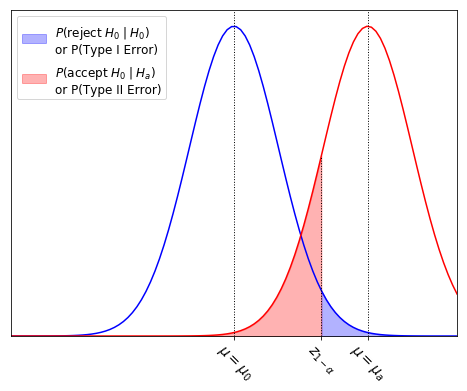

In [0]:
#@title Plot of Type I and Type II Errors
delta = 3
mu_0 = 0 
mu_a = mu_0 + delta

null_dist = ss.norm(mu_0,1)
alt_dist = ss.norm(mu_a, sigma)

x_min = -5
x_max = 5
alpha = 0.05
x = np.linspace(x_min,x_max,100)
y = null_dist.pdf(x)
y_a = alt_dist.pdf(x)

type_I_error_region = np.linspace(null_dist.ppf(1-alpha/2), x_max, 50)
type_II_error_region = np.linspace(x_min, null_dist.ppf(1-alpha/2), 50)

plt.figure(1, figsize=[8,6])

plt.plot(x, y, color="blue") # Plot Null PDF
plt.plot(x,y_a, color="red") # Plot Alternative PDF

# Plot null hypothesis mean
plt.axvline(x = null_dist.mean(), 
            ymax = null_dist.pdf(null_dist.mean())/0.4,
            ls=":", 
            lw = 1,
            color="k")

# Plot null hypothesis mean
plt.axvline(x = alt_dist.mean(), 
            ymax = alt_dist.pdf(alt_dist.mean())/0.4,
            ls=":", 
            lw = 1,
            color="k")

# Plot rejection boundary
plt.axvline(x = null_dist.ppf(1-alpha/2), 
            ymax = null_dist.pdf(1-alpha/2)/0.45,
            ls=":", 
            lw = 1,
            color="k")


# Plot Type I probability
plt.fill_between(x = type_I_error_region, 
                 y1 = 0, 
                 y2 = null_dist.pdf(type_I_error_region),
                 color = 'blue',
                 alpha = 0.3,
                 label = r"""$P({\rm reject\; }H_0\;|\;H_0)$""" + "\nor P(Type I Error)")

# Plot Type I probability
plt.fill_between(x = type_II_error_region, 
                 y1 = 0, 
                 y2 = alt_dist.pdf(type_II_error_region),
                 color = 'red',
                 alpha = 0.3,
                 label = r"""$P({\rm accept\; }H_0\;|\;H_a)$""" + "\nor P(Type II Error)")

plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1,prop={'size': 12})
plt.xticks([0, null_dist.ppf(1-alpha/2), mu_0 + delta], 
           [r"$\mu=\mu_0$", r"$z_{1-{\alpha}}$",r"$\mu=\mu_a$"],
           fontsize=14,
           rotation=-45)
plt.yticks([])
plt.ylim(0,.42)
plt.xlim([x_min,x_max])
plt.show()

### Two-Sample $z$-test
Most often for A/B test we don't want to compare something to a  known value. We want to compare two different samples. e.g. we want to compare one group ($A$) who saw the blue button vs the other group ($B$) who saw the red button. This is a simple change: instead of testing a mean $\mu$ against some fixed value $\mu_0$, we compare the difference of means $\mu_A-\mu_B$ against a fixed value, namely $\mu_0=0$. The assumptions are also similar:


The assumptions are:
  1. a. Each data point from group $A$, $y_{Ai}$ comes from a normal random variable $Y_A\sim\mathcal N (\mu_A,\sigma^2)$
  
     b. Each data point from group $A$, $y_{Bi}$, comes from a normal random variable $Y_B\sim\mathcal N (\mu_B,\sigma^2)$
  2. a. We know the variance, $\sigma_A^2$, of population $A$
  
  b. We know the variance, $\sigma_B^2$, of population $B$.
  
  3.  a. We don't know the mean $\mu_A$ of group $A$.
  
  b. We don't know the mean $\mu_B$ of group $B$.

So the two-sided hypothesis for comparing means from sample $A$ and sample $B$ we have:
\begin{align*}
  H_0 &: \mu_A-\mu_B = 0        &\text{or$\hspace{1cm}$}&&  H_0 &: \mu_A = \mu_B \\
  H_1 &: \mu_A-\mu_B \neq 0  &\text{ equivalently }&&  H_1 &: \mu_A \neq \mu_B\\
\end{align*}

The test statistic is then 
$$z = \frac{\bar y_A - \bar y_B}
          {\sqrt{\frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}}}$$
Where $\bar X_A$ and $\bar X_B$ are the sample means for group $A$ and $B$, where $n_A$ and $n_B$ are the sample sizes of groups $A$ and $B$.

From here, we follow the same steps to get the $p$-value:
$$p = 2\cdot  F_Z (-|z|)$$

Analogously, (and without loss of generality) we can do a one-sided test where we can change the alternative hypothesis to $H_1: \mu_A-\mu_B > 0$, which is equivalent to $H_1: \mu_A>\mu_B$. And we get the $p$-value the same way with the one-sample test:
$$p= 1 -  F_Z (z)$$


### The $t$-test

#### The $t$-distribution
The $t$-test can be thought of as a generalization of the $z$ test. We remove the assumption that the variance $\sigma^2$ is known. Instead we assume that the variance is distributed according to Pearson's Chi-squared i.e. $\sigma^2\sim\chi^2_\nu$. When you do that you end up with a $t$-distribution. So in fact 
$$\frac{\mathcal N(0,1)}{\chi^2_\nu}=t_\nu$$
If you want to see all of the details as to why this is, there is a [paper](https://shoichimidorikawa.github.io/Lec/ProbDistr/t-e.pdf) and a [moving picture ](https://www.youtube.com/watch?v=jFOyzEJctUU) that goes though it all. 

The main take-aways from this is that since we don't know the variance we don't know how much to sway away from the mean. This translates to having fatter tails on the $t$-distribution. Moreover, as we gather data, we can be more and more sure of the true variance so the $t$-distribution converges to the $z$-distribution. In the animation below we can see what happens as we increase the size of the data set $N$.
<center>
<img align="center" src="https://media.giphy.com/media/U5VhygwSG6jK6MNRW9/giphy.gif" width="480" />
</center>


Notice how quickly the $t$-distribution (in blue) converges to the $z$-distribution in orange. With as few as 30 data points, they are almost indistinguishable. In data science we are often dealing with data sets much larger than 30 so the difference between the $z$ and $t$ tests have been muddled in the data science world without much of a consequence. 

#### The One Sample Test
For the $t$-test we start off almost exactly as the $z$ test. We use the same hypothesis. In the one-sample test, we use:
\begin{align*}
\text{For two-sided}   &&      && \text{For one-sided (left)}      &&&& \text{For one-sided (right)}\\
H_0: \mu=\mu_0       && or &&H_0: \mu=\mu_0  && or &&H_0: \mu=\mu_0\\
H_a: \mu\neq \mu_0 &&     &&H_a: \mu< \mu_0  &&     &&H_a: \mu> \mu_0\\
\end{align*}

The test statistic is almost the same except now we don't know the true standard deviation, so we approximate it with the sample standard deviation, $s$. 

$$
  t = \frac{\mu_o - \bar y}{s/\sqrt{n}}\sim t_{n-1}, \hspace{1cm}\text{where } 
  s = \sqrt{\frac{\sum_{i=1}^{n}(y_i - \bar y)^2}{n-1}}
$$

Now instead of using the standard normal CDF $F_Z$, we will user the $t_{n-1}$ CDF which we donote $F_{t_{n-1}}$.

\begin{align*}
\text{For two-sided}   &&      && \text{For one-sided (right)}      &&&& \text{For one-sided (left)}\\
p = 2\cdot F_{t_{n-1}}(-|t|)      && or && p= F_{t_{n-1}}(t)&& or &&p=1-F_{t_{n-1}}(t)
\end{align*}




### Two sample $t$-test
With the one-sample $t$-test defined and the two-sample $z$ test defined, you can probably guess what the test statistic for a two sided $t$ test is:


In [0]:
sao_paulo_data = arpu_df[arpu_df.index==11]
rio_de_janeiro_data = arpu_df[arpu_df.index==21]

sm.stats.ttest_ind(sao_paulo_data,  
                   rio_de_janeiro_data, 
                   alternative='two-sided',
                   usevar='unequal')

(array([11.12125036]), array([2.64665174e-28]), array([3864.81753001]))

In [0]:
sm.stats.ztest(sao_paulo_data,  
                   rio_de_janeiro_data, 
                   alternative='two-sided')

(array([11.12125036]), array([9.88764399e-29]))

#### Paired vs. unpaired
It is rare to use a paired test for A/B test in data science, however it is worth knowing the difference. For an unpaired test, each participant in the study receives exactly one treatment, i.e. each participant is either in group A or group B but never in both. 

In the paired scenario, we give each participant both treatment A and treatment B. The assumption is that the first treatment will not affect the outcome of the second treatment. A possible example of a paired test could be if we wanted to test if shoes A or shoes B helped the wearer with the height of their jumps. We can have each person try on shoes A and shoes B and jump and we can measure their height. And it seems safe to assume that their jumping ability will not change significantly from the first jump to the second jump. 

Paired test are nice since you would need fewer participants.




,expected,observed
Sao Paulo,212566.0,693020.0
Rio De Janeiro,387150.0,613285.0
Other,6063804.0,5357216.0


Chi-sq Statistic:	1300371.39027
Degrees Of Freedom:	2
P-Value:		0.0


# Glossary

***Probability Density Function (PDF)*** the PDF is the function that uniquely characterizes a probability distribution or a random varaiable $Y$ and is denoted $f_Y(y)$. It satisfies the following properties:

- $f_Y(y) \geq 0$ for any $y\in \mathbb R$
- $\int_\mathbb R f_Y(y) dy = 1$
- $\int_a^b f_Y(y) dy = P(a\leq Y\leq b)$

***Cummulative Distribution Function (CDF)*** the CDF is the function that uniquely characterizes a probability distribution or a random varaiable $Y$ and is denoted $F_Y(y)$. It satisfies the following properties:

- $\lim_{y\to-\infty} F_Y(y) = 0$
- $\lim_{y\to \infty} F_Y(y) = 1$
- $F_Y(a) = \int_{-\infty}^{a}f_Y(y)dy = P(y\leq a)$

Note for the standard normal distribution $z$, the CDF is denoted $F_Z(y)$.

 ***Expected Value*** The expected value of a random variable $Y$ is denoted $\mathbb E(Y)$ and is defined by 
 $$\mathbb E(Y) = \int_\mathbb R y\cdot f_Y(y) dy$$
 
 ***Variance*** The variance of a random variable $Y$ is denoted $var(Y)$ and is defined as 
 $$ var(Y) = \int_\mathbb R \big(y-\mathbb E(Y)\big)^2\cdot f_Y(y) dy$$